# Setup

In [1]:
# Used to read .env files, for access tokens and other secrets or configurations
%load_ext dotenv
%dotenv
import os

In [98]:
from github import Github
import pandas
from matplotlib import pyplot
import numpy
import seaborn

from datetime import datetime, timedelta

In [3]:
# The github token is stored in a .env file next to this notebook in the form "GITHUB_TOKEN = <your token here>"
g = Github(os.getenv("GITHUB_TOKEN"))

# Team Constants

These are things that describe how the team work and are static

## Team Members

In [5]:
sap = g.get_organization('SAP')
def is_company_member(named_user):
    return ('SAP' in (named_user.company or '').upper()) or named_user.login.upper().endswith('SAP') or sap.has_in_members(named_user)

In [6]:
cwa = g.get_organization('corona-warn-app')
team = list(filter(is_company_member, cwa.get_members()))
team

[NamedUser(login="AdnanZiSAP"),
 NamedUser(login="christian-kirschnick"),
 NamedUser(login="christianneu"),
 NamedUser(login="EvgeniiSkrebtcov"),
 NamedUser(login="haosap"),
 NamedUser(login="hilmarf"),
 NamedUser(login="inf2381"),
 NamedUser(login="johanneseschrig"),
 NamedUser(login="johannesrohwer"),
 NamedUser(login="MalteJ"),
 NamedUser(login="marcauberer"),
 NamedUser(login="Marco2907"),
 NamedUser(login="mibrasap"),
 NamedUser(login="michael-burwig"),
 NamedUser(login="mlenkeit"),
 NamedUser(login="PetrusVanHeaven"),
 NamedUser(login="pithumke"),
 NamedUser(login="SebastianWolf-SAP"),
 NamedUser(login="steins-code"),
 NamedUser(login="T-Bendrath"),
 NamedUser(login="tkowark")]

## Sprint Management

In [7]:
# In the following, we will assume that sprints are totally regular, starting with a fixed date.
# The helper functions can of course be adapted to represent, e.g., changes in sprint duration or holiday breaks

start_date_first_sprint = datetime(2020, 4, 27) # It's a monday, development actually started 02.05.2020
sprint_length = timedelta(weeks=2)

def date_to_sprint(date_to_convert):
    return max(0, (date_to_convert - start_date_first_sprint) // sprint_length + 1) # Sprint "0" is everything before the first

def sprint_to_start_date(sprint_to_convert):
    return start_date_first_sprint + (sprint_to_convert - 1) * sprint_length

## Repos

In [8]:
server_repo = g.get_repo('corona-warn-app/cwa-server')
# Let's assume that all developers with less than 5 commits were not active developers
server_contributors = map(lambda stats: stats.author, filter(lambda stats: stats.total >= 5, server_repo.get_stats_contributors()))
server_team = list(filter(is_company_member, server_contributors))
server_team

[NamedUser(login="tkowark"),
 NamedUser(login="EvgeniiSkrebtcov"),
 NamedUser(login="emmetsap"),
 NamedUser(login="UnchartedBull"),
 NamedUser(login="mlenkeit"),
 NamedUser(login="CCFenner"),
 NamedUser(login="MKusber"),
 NamedUser(login="ole-lilienthal"),
 NamedUser(login="kilbphilippSAP"),
 NamedUser(login="KevponSAP"),
 NamedUser(login="stevesap"),
 NamedUser(login="christian-kirschnick"),
 NamedUser(login="AliceBilc"),
 NamedUser(login="EugenM-SAP"),
 NamedUser(login="roesslerj"),
 NamedUser(login="johanneseschrig"),
 NamedUser(login="pithumke"),
 NamedUser(login="michael-burwig"),
 NamedUser(login="mibrasap"),
 NamedUser(login="hilmarf")]

# Example: Issue Arrival Analysis

## Data Collection and Preprocessing

In [9]:
repo = server_repo

In [199]:
issues_raw = repo.get_issues(state='all')
issues_dataframe = pandas.DataFrame(issues_raw, columns=['issue'])
issues_dataframe

,issue
0,"Issue(title=""Bump versions-maven-plugin from 2..."
1,"Issue(title=""Bump s3 from 2.17.182 to 2.18.1"",..."
2,"Issue(title=""Bump s3 from 2.17.182 to 2.18.0"",..."
3,"Issue(title=""Bump spring-boot.version from 2.7..."
4,"Issue(title=""Bump protobuf.version from 3.21.7..."
...,...
1911,"Issue(title=""Index File Generation"", number=6)"
1912,"Issue(title=""Set Retention Days to 14"", number=5)"
1913,"Issue(title=""Setup Wiki"", number=9)"
1914,"Issue(title=""DDoS protection"", number=2)"


In [12]:
issues_opened_per_sprint = issues_dataframe.groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index].issue.created_at)))
issues_opened_per_sprint

In [13]:
closed_issues = issues_dataframe[issues_dataframe.apply(lambda x: x.issue.closed_at is not None, axis=1)]
issues_closed_per_sprint = closed_issues.groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index].issue.closed_at)))
issues_closed_per_sprint

In [43]:
issues = pandas.DataFrame(index=range(0, date_to_sprint(datetime.today())+1)) # The range ensures that there are rows for sprints where no issues were opened or closed
issues.index.name = 'sprint'
issues['opened'] = issues_opened_per_sprint.count().astype('Int64')
issues['closed'] = issues_closed_per_sprint.count().astype('Int64')
issues = issues.fillna(0) # Replace NaN values from outer join with zero
issues['open_at_start'] = (issues.opened - issues.closed).cumsum().shift(fill_value=0) # Issues open at start of each sprint = sum of issues opened - closed beforea
issues

,opened,closed,open_at_start
sprint,,,
0,0,0,0
1,60,39,0
2,227,201,21
3,175,199,47
4,137,123,23
...,...,...,...
62,10,12,4
63,14,12,2
64,16,17,4


## Analyze

In [212]:
start_sprint = date_to_sprint(datetime(2022, 1, 1)) # Using date here to be able to explore sprint length
end_sprint = date_to_sprint(datetime(2022, 10, 1))

In [213]:
issues_focus = issues[(issues.index >= start_sprint) & (issues.index <= end_sprint)]
issues_focus

,opened,closed,open_at_start
sprint,,,
44,14,13,12
45,22,28,13
46,8,6,7
47,22,24,9
48,20,22,7
49,15,15,5
50,10,9,5
51,19,19,6
52,16,15,6


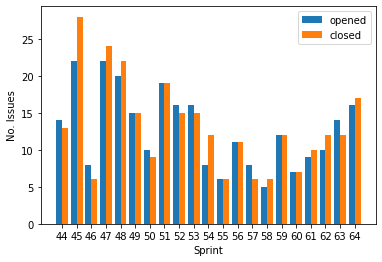

In [214]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index-0.2, issues_focus['opened'], width=0.4)
pyplot.bar(issues_focus.index+0.2, issues_focus['closed'], width=0.4)
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
axes.legend(['opened', 'closed'])
print() # silence output from command before

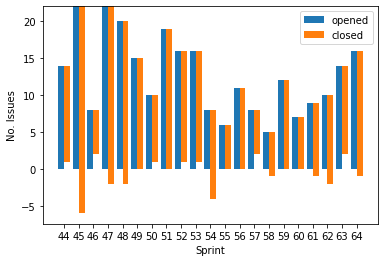

In [215]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index-0.2, issues_focus['opened'], width=0.4)
pyplot.bar(issues_focus.index+0.2, -issues_focus['closed'], bottom=issues_focus['opened'], width=0.4)
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
axes.legend(['opened', 'closed'])
print() # silence output from command before

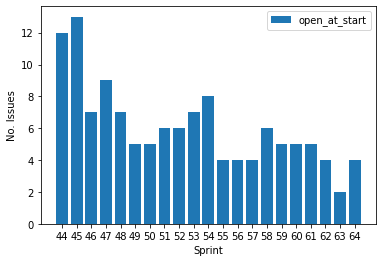

In [216]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index, issues_focus['open_at_start'])
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
axes.legend(['open_at_start'])
print() # silence output from command before

In [227]:
for sprint in range(55, 64+1):
    open = issues_dataframe[issues_dataframe.apply(lambda x: date_to_sprint(x.issue.created_at) < sprint and ((x.issue.closed_at is None) or (date_to_sprint(x.issue.closed_at) >= sprint)), axis=1)]
    open = open.apply(lambda x: [x.issue.number, x.issue.title], axis=1)
    print('Sprint: '+str(sprint)+': ')
    print(open.values)

Sprint: 55: 
[list([1797, 'Failed to instantiate distribution service [release - cwa-server-2.19.0]'])
 list([1793, 'Kubernetes deployments'])
 list([1575, 'Quantitative analysis on the CWA code base performed using data provided by Git'])
 list([1027, 'Feature/optimized dockerfiles'])]
Sprint: 56: 
[list([1797, 'Failed to instantiate distribution service [release - cwa-server-2.19.0]'])
 list([1793, 'Kubernetes deployments'])
 list([1575, 'Quantitative analysis on the CWA code base performed using data provided by Git'])
 list([1027, 'Feature/optimized dockerfiles'])]
Sprint: 57: 
[list([1797, 'Failed to instantiate distribution service [release - cwa-server-2.19.0]'])
 list([1793, 'Kubernetes deployments'])
 list([1575, 'Quantitative analysis on the CWA code base performed using data provided by Git'])
 list([1027, 'Feature/optimized dockerfiles'])]
Sprint: 58: 
[list([1854, 'modified the country and period range'])
 list([1851, 'Bump feign.version from 11.8 to 11.9'])
 list([1797, '

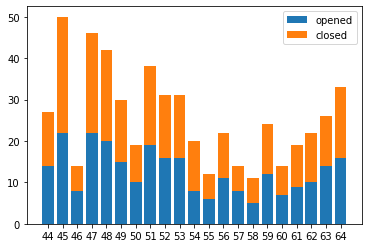

In [217]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index, issues_focus['opened'])
pyplot.bar(issues_focus.index, issues_focus['closed'], bottom=issues_focus['opened'])
axes.set_xticks(issues_focus.index)
axes.legend(['opened', 'closed'])
print() # silence output from command before

# Experiment Zone

In [91]:
list(map(lambda x: [x.event, x.label], server_repo.get_issue(1).get_events()))

[['transferred', None],
 ['milestoned', None],
 ['labeled', Label(name="DistributionSvc")],
 ['mentioned', None],
 ['subscribed', None],
 ['closed', None],
 ['referenced', None],
 ['referenced', None]]

In [75]:
events = list(server_repo.get_issue(1).get_timeline())
events

[TimelineEvent(id=3296168633),
 TimelineEvent(id=623087220),
 TimelineEvent(id=None),
 TimelineEvent(id=3320405293),
 TimelineEvent(id=3320405498),
 TimelineEvent(id=629121190),
 TimelineEvent(id=3340026300),
 TimelineEvent(id=3340026305),
 TimelineEvent(id=629200722),
 TimelineEvent(id=3340651840),
 TimelineEvent(id=3366273615),
 TimelineEvent(id=3496768028)]

In [114]:
list(map(lambda x: [x.source and x.source.type, x.event, x.], events))

[[None, 'transferred'],
 [None, 'commented'],
 ['issue', 'cross-referenced'],
 [None, 'milestoned'],
 [None, 'labeled'],
 [None, 'commented'],
 [None, 'mentioned'],
 [None, 'subscribed'],
 [None, 'commented'],
 [None, 'closed'],
 [None, 'referenced'],
 [None, 'referenced']]

In [102]:
list(map(lambda x: [x.event, x.source, x.node_id], events))

[['transferred', None, 'MDE2OlRyYW5zZmVycmVkRXZlbnQzMjk2MTY4NjMz'],
 ['commented', None, 'MDEyOklzc3VlQ29tbWVudDYyMzA4NzIyMA=='],
 ['cross-referenced', TimelineEventSource(type="issue"), None],
 ['milestoned', None, 'MDE1Ok1pbGVzdG9uZWRFdmVudDMzMjA0MDUyOTM='],
 ['labeled', None, 'MDEyOkxhYmVsZWRFdmVudDMzMjA0MDU0OTg='],
 ['commented', None, 'MDEyOklzc3VlQ29tbWVudDYyOTEyMTE5MA=='],
 ['mentioned', None, 'MDE0Ok1lbnRpb25lZEV2ZW50MzM0MDAyNjMwMA=='],
 ['subscribed', None, 'MDE1OlN1YnNjcmliZWRFdmVudDMzNDAwMjYzMDU='],
 ['commented', None, 'MDEyOklzc3VlQ29tbWVudDYyOTIwMDcyMg=='],
 ['closed', None, 'MDExOkNsb3NlZEV2ZW50MzM0MDY1MTg0MA=='],
 ['referenced', None, 'MDE1OlJlZmVyZW5jZWRFdmVudDMzNjYyNzM2MTU='],
 ['referenced', None, 'MDE1OlJlZmVyZW5jZWRFdmVudDM0OTY3NjgwMjg=']]

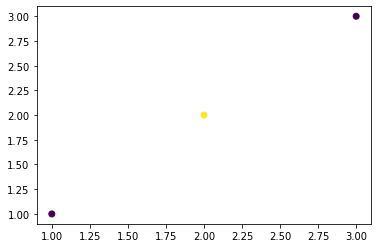

In [97]:
figure, axes = pyplot.subplots()
c = ['a', 'b', 'a']
colors = numpy.linspace(0, 1, len(numpy.unique(c)))
colordict = dict(zip(c, colors))  
color_col = list(map(lambda x: colordict[x], c))
axes.scatter([1, 2, 3], [1, 2, 3], c=color_col)

In [103]:
issues_raw = repo.get_issues(state='all')

In [120]:
events = []
for issue in issues_raw:
    if issue.created_at >= datetime(2022, 1, 1):
        events.extend(map(lambda event: (issue.number, event), issue.get_timeline()))
events[0:100]

[(1939, TimelineEvent(id=None)),
 (1939, TimelineEvent(id=7649643552)),
 (1939, TimelineEvent(id=7649643561)),
 (1939, TimelineEvent(id=7649643564)),
 (1939, TimelineEvent(id=7649643574)),
 (1939, TimelineEvent(id=1288329162)),
 (1938, TimelineEvent(id=None)),
 (1938, TimelineEvent(id=7649642264)),
 (1938, TimelineEvent(id=7649642270)),
 (1938, TimelineEvent(id=7649642273)),
 (1938, TimelineEvent(id=7649642300)),
 (1938, TimelineEvent(id=None)),
 (1938, TimelineEvent(id=7649642503)),
 (1938, TimelineEvent(id=1288329051)),
 (1937, TimelineEvent(id=None)),
 (1937, TimelineEvent(id=7636492757)),
 (1937, TimelineEvent(id=7636492780)),
 (1937, TimelineEvent(id=7636492793)),
 (1937, TimelineEvent(id=7636492834)),
 (1937, TimelineEvent(id=1286383483)),
 (1937, TimelineEvent(id=1288306434)),
 (1937, TimelineEvent(id=7649642424)),
 (1937, TimelineEvent(id=7649642514)),
 (1936, TimelineEvent(id=None)),
 (1936, TimelineEvent(id=7636492373)),
 (1936, TimelineEvent(id=7636492406)),
 (1936, Timeline

In [192]:
create_events = map(lambda issue: ({'issue': issue.number, 'time': issue.created_at, 'event': 'created'}),filter(lambda issue: issue.created_at >= datetime(2022, 1, 1), issues_raw))
create_events

In [193]:
events_dataframe = pandas.DataFrame.from_records([[tup[0], tup[1].created_at, tup[1].event] for tup in events], columns=['issue', 'time', 'event'])
events_dataframe = events_dataframe.append(pandas.DataFrame.from_records(create_events, columns=['issue', 'time', 'event']))
events_dataframe

,issue,time,event
0,1939,NaT,committed
1,1939,2022-10-24 02:04:43,review_requested
2,1939,2022-10-24 02:04:43,review_requested
3,1939,2022-10-24 02:04:43,review_requested
4,1939,2022-10-24 02:04:43,labeled
...,...,...,...
260,1679,2022-01-04 14:37:14,created
261,1678,2022-01-04 13:22:42,created
262,1677,2022-01-04 12:06:23,created
263,1676,2022-01-03 11:22:00,created


In [194]:
numpy.unique(events_dataframe.event)

array(['assigned', 'auto_merge_disabled', 'auto_squash_enabled',
       'base_ref_changed', 'closed', 'commented', 'committed',
       'convert_to_draft', 'created', 'cross-referenced', 'demilestoned',
       'head_ref_deleted', 'head_ref_force_pushed', 'head_ref_restored',
       'labeled', 'mentioned', 'merged', 'milestoned', 'ready_for_review',
       'referenced', 'renamed', 'review_dismissed',
       'review_request_removed', 'review_requested', 'reviewed',
       'subscribed'], dtype=object)

In [195]:
event_whitelist = ['created', 'committed', 'review_requested', 'labeled', 'commented', 'cross-referenced', 'closed', 'ready_for_review', 'reviewed', 'milestoned', 'merged', 'assigned', 'referenced', 'mentioned']
events_filtered = events_dataframe[events_dataframe.apply(lambda x: x.event in event_whitelist, axis=1)]
palette = dict(zip(event_whitelist, seaborn.color_palette(n_colors=len(event_whitelist))))

<AxesSubplot:xlabel='time', ylabel='issue'>

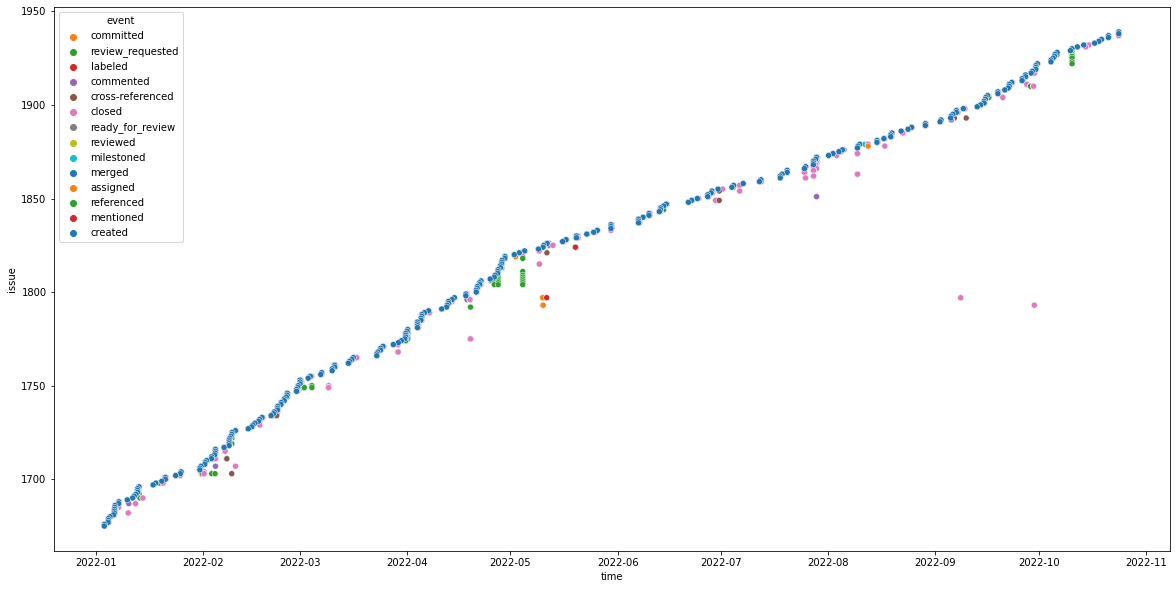

In [196]:
pyplot.figure(figsize=(20, 10))
seaborn.scatterplot(data=events_filtered, x='time', y='issue', hue='event', palette=palette)

<AxesSubplot:xlabel='time', ylabel='issue'>

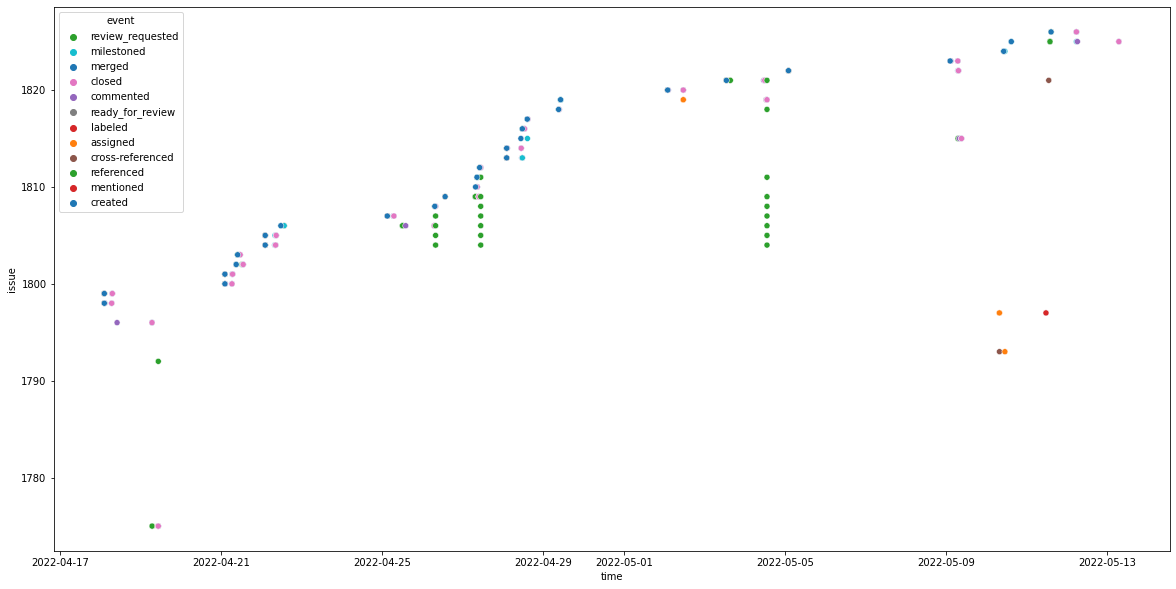

In [198]:
events_focus = events_filtered[events_filtered.apply(lambda x: x.time >= datetime(2022, 4, 15) and x.time <= datetime(2022, 5, 15),  axis=1)]
pyplot.figure(figsize=(20, 10))
seaborn.scatterplot(data=events_focus, x='time', y='issue', hue='event', palette=palette)